# **Word Embeddings**


## **Topic Introduction & Approach (Thought Process)**

The main goal of this project is to train own word embeddings and compare those to pre-trained word embeddings with regard to similarity of frequent as well as domain-specific words. As data source, extracted article descriptions from Wikipedia are used. They are divided into the two categories *Programming Languages* and *Literary Genres* which allows to make comparisons between word embeddings trained on the individual categories and on both together (no distinction between categories = 1 corpus).   

Hence, the following approach is used:\
For start, the five most frequent words per category (programming languages and literary genres) are defined based on word count. These words serve as base to compare the different word embeddings (i.e., sel-trained word embeddings vs. pre-trained word embeddings).

Then the actual embedding is performed whereby several approaches are used. First, the word embeddings are trained category-wise (each category gets its own word embeddings) whereby a distinction is made between embeddings with and without stop words. The reason behind this is that removing stop words may be beneficial or not depending on the use case. An argument in favor of removing them is that they do not contain any useful information about the content of a text by themselves and therefore could be omitted. On the other hand, keeping them provides information about the context as well as the sentence representation. A use case for not removing stop words is feeding a contextual model like BERT where they are kept to provide information about the context. Since the word embeddings derived in this project are not used to feed any model, both approaches (with and without stop words) are carried out in order to investigate differences between them. Furthermore, additional self-trained word embeddings are created which do not distinguish between the categories.  

As another step, pre-trained word embeddings from GloVe and Fasttext are used to derive the most similar words for the Top5 words of each category in order to compare the outputs to the self-trained word embeddings. Those were trained by someone else on larger datasets and are therefore more general or less tied to categories as the self-trained one's. Whether this is aspirational or not depends again on the use case. 

Lastly, sysnsets of the most Top5 words per category are accessed from WordNet and compared to the self- and pre-trained word embeddings. 



## **Requirements & Configurations**

The required libraries are imported and some configurations are set as a first step.

In [ ]:
# Import required libraries 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt
import spacy
import gensim.downloader as api

nltk.download('punkt')
nltk.download('wordnet')

from pathlib import Path
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from gensim.models import Word2Vec
from collections import Counter
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Adjust settings for pandas library
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## **Data**

As already mentioned, the input data to generate the word embeddings are article descriptions derived from Wikipedia based on the following two categories:


*   Programming Languages
*   Literary Genres

The idea behind this is to compare word embeddings that are created based on the corresponding category vs. embeddings that are created based on both categories. The assumption is that word embeddings with no category distinction lead to more generality because they are trained on a more general/less domain-specific dataset and therefore are less prone to overfitting (i.e., the similarity between two words very domain-specific words gets reduced). 

In this chapter, the data is loaded and some basic inspection tasks are conducted to get some information about it. 



In [ ]:
# Load the data 
df = pd.read_csv('https://gitlab.com/mfrrr/hslu_nlp/-/raw/main/wiki_descriptions.csv', sep=',')

In [ ]:
# Display the first two rows of the dataframe for illustration purposes
df.head(2)

Category                       Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description
0  Programming                ActionScript                                      ActionScript is an object-oriented programming language originally developed by Macromedia Inc. (later acquired by Adobe Systems). It is influenced by HyperTalk, the scripting language for HyperCard. It is now an implementation of ECMAScript (meaning it is a superset of the syntax and semantics of the language more widely known as JavaScript), though it originally arose as a sibling, both being influenced by HyperTalk.\nActionScript is used primarily for the development of websites and software targeting the Adobe Flash Player platform, used on Web pages in the form of embedded SWF files.\nActionScript 3 is also used with Adobe AIR system for the development of desktop and mobile applications. The language itself is open-source in that its specification is offered free of charge and both an open source compiler (as part of Apache Flex) and open source virtual machine (Mozilla Tamarin) are available.\nActionScript was also used with Scaleform GFx for the development of 3D video game user interfaces and HUDs.
1  Programming  Ada (programming language)  Ada is a structured, statically typed, imperative, and object-oriented high-level programming language, extended from Pascal and other languages. It has built-in language support for design by contract (DbC), extremely strong typing, explicit concurrency, tasks, synchronous message passing, protected objects, and non-determinism. Ada improves code safety and maintainability by using the compiler to find errors in favor of runtime errors. Ada is an international technical standard, jointly defined by the International Organization for Standardization (ISO), and the International Electrotechnical Commission (IEC). As of 2020, the standard, called Ada 2012 informally, is ISO/IEC 8652:2012.Ada was originally designed by a team led by French computer scientist Jean Ichbiah of CII Honeywell Bull under contract to the United States Department of Defense (DoD) from 1977 to 1983 to supersede over 450 programming languages used by the DoD at that time. Ada was named after Ada Lovelace (1815–1852), who has been credited as the first computer programmer.

In [ ]:
# Inspect dimensionality of dataframe
print('Number of rows: ', df.shape[0])
print('Number of columns: ', df.shape[1])

Number of rows:  352
Number of columns:  3


In [ ]:
# Print information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     352 non-null    object
 1   Title        352 non-null    object
 2   Description  352 non-null    object
dtypes: object(3)
memory usage: 8.4+ KB


In [ ]:
# Compute descriptive statistics of the dataframe
df.describe(include = [object])

Category         Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Description
count          352           352                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             352
unique           2           352                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             352
top     Literature  ActionScript  ActionScript is an object-oriented programming language originally developed by Macromedia Inc. (later acquired by Adobe Systems). It is influenced by HyperTalk, the scripting language for HyperCard. It is now an implementation of ECMAScript (meaning it is a superset of the syntax and semantics of the language more widely known as JavaScript), though it originally arose as a sibling, both being influenced by HyperTalk.\nActionScript is used primarily for the development of websites and software targeting the Adobe Flash Player platform, used on Web pages in the form of embedded SWF files.\nActionScript 3 is also used with Adobe AIR system for the development of desktop and mobile applications. The language itself is open-source in that its specification is offered free of charge and both an ope

## **Text Cleaning & Preprocessing**

In this section, some preprocessing tasks are performed to standardize the data. Furthermore, the texts are also tokenized since tokens serve as inputs for the word embeddings. Regard to the resulting tokens, there is a column with and one without stop words in order to compare the word embeddings with regard to that aspect. 

In [ ]:
# Define a function to perform basic normalization tasks
def normalization(doc):
  # Remove special characters (except full stop, question mark and exclamation)
  doc = re.sub(r'[^A-Za-z0-9 \-+]+', ' ', doc, re.I | re.A)
  # Remove line breaks
  doc = doc.replace('\n', ' ')
  # Remove whitespaces
  doc = doc.strip()
  # Transform to lowercase
  doc = doc.lower()
  return doc
# Call function to perform normalization
df['Description'] = df['Description'].apply(lambda x: normalization(x))

In [ ]:
# Define a function for word tokenization
def word_tokenization(doc):
  word_token_list = []
  for word in word_tokenize(doc):
    word_token_list.append(word.strip())
  return list(word_token_list)
# Call function to perform word tokenization 
df['Tokens'] = df['Description'].apply(lambda x: word_tokenization(x))

In [ ]:
# Create a NLP object
nlp = spacy.load('en_core_web_sm')
# Define the stop words (default stop words from spacy)
stop_words = nlp.Defaults.stop_words
# Define a function to remove stop words
def stop_word_removal(tokens):
  tokens_wo_stops = []
  for token in tokens:
    if token not in stop_words:
      tokens_wo_stops.append(token)
    else:
      continue
  return tokens_wo_stops
# Call function and perform stop word removal
df['Tokens (w/o Stop Words)'] = df['Tokens'].apply(lambda x: stop_word_removal(x))

In [ ]:
# Define function to remove punctuation marks and the 's' from tokens
def remove_punctuation(doc):
  for element in doc:
    if element == '.':        # Reassure that all punctuation marks really got removed
      doc.remove(element)
    if element == 's':        # Remove possesive "'s" resulted as single token after special characters removal
      doc.remove(element)
  return doc
# Call function to perform punctuation removal
df['Tokens'] = df['Tokens'].apply(lambda x: remove_punctuation(x))
df['Tokens (w/o Stop Words)'] = df['Tokens (w/o Stop Words)'].apply(lambda x: remove_punctuation(x))

## **Top5 Content Words per Category**

To compare the different word embeddings, the five most frequent content words are computed by category.

In [ ]:
# Find the five most frequent content words in the descriptions of category 'Programming'
def get_top5_programming(df):
  tokens_list_programming = []
  for ind in df.index:
    tokens = df['Tokens (w/o Stop Words)'][ind]
    for token in tokens:
      tokens_list_programming.append(token)
  counter = Counter(tokens_list_programming)
  top10_freq_programming = counter.most_common(5) 
  return top10_freq_programming
# Call function to compute Top5 most frequent content words 
get_top5_programming(df[df['Category'] == 'Programming'])

[('language', 406),
 ('programming', 300),
 ('languages', 95),
 ('code', 78),
 ('developed', 74)]

In [ ]:
# Define Top5 token for the category 'Programming' as a list
top5_programming = ['language', 'programming', 'languages', 'code', 'developed']

In [ ]:
# Find the five most frequent content words in the descriptions of category 'Literature'
def get_top5_literature(df):
  tokens_list_literature = []
  for ind in df.index:
    tokens = df['Tokens (w/o Stop Words)'][ind]
    for token in tokens:
      tokens_list_literature.append(token)
  counter = Counter(tokens_list_literature)
  top10_freq_literature = counter.most_common(5) 
  return top10_freq_literature
# Call function to compute Top5 most frequent content words 
get_top5_literature(df[df['Category'] == 'Literature'])

[('fiction', 248),
 ('genre', 246),
 ('novel', 160),
 ('novels', 135),
 ('literature', 134)]

In [ ]:
# Define Top5 token for the category 'Literature' as a list
top5_literature = ['fiction', 'genre', 'novel', 'novels', 'literature']

## **Self-trained Word Embeddings - Word2Vec**

The self-trained word embeddings are computed with *Word2Vec* and the *CBOW* training algorithm resulting in the prediction of a single word from a fixed window size of context words. The opposite option would be the *Skip-Gram* training algorithm. The selection between those two should be based on the problem to be solved since CBOW emphasizes on syntactic relationships between words rather than semantic one's (Skip-Gram). CBOW is chosen for this project since it is found to train faster than Skip-Gram and can better represent more frequent words (remember: we use the most frequent words as comparison base) according to Mikolov et al. (2013)*. 

First, the word embeddings are trained seperatly by categories always on a list of token with and without stop words to investigate differences. Second, another word embedding is performed on the entire set of descriptions without distinguishing between the categories. 

*Reference: https://arxiv.org/pdf/1301.3781.pdf 

### **Category: Programming Languages**

In this section, word embeddings for the descriptions of the category 'Programming Languages' are computed. Since word embeddings with and without stop words created and compared, the following assumption is made: When looking at the most similar words to the Top5, word embeddings including stop words will mainly retrieve stop words as most similar while word embeddings excluding stop words will obvisousely retrieve content words based on syntactic similarity. This assumption is based on ability of CBOW to better represent more frequent words and stop words tend to appear more frequent than content words. 

In [ ]:
# Create a subset with programming languages only
df_programming = df[df['Category'] == 'Programming']

In [ ]:
# Set seed for reproducibility
random.seed(1)
# Set values for parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

# Create model and train embedding space using word2vec architecture ('CBOW' as training algorithm) - stop words are included
w2v_programming_sw = Word2Vec(sentences=df_programming['Tokens'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0) # CBOW
# Create model and train embedding space using word2vec architecture ('CBOW' as training algorithm) - stop words are excluded
w2v_programming = Word2Vec(sentences=df_programming['Tokens (w/o Stop Words)'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0) # CBOW

In [ ]:
# Get five most similar words to each of the five most frequent words (with stop words)
for word in top5_programming:
  print(word+':', w2v_programming_sw.wv.most_similar(word, topn=5))
print(182*'=')
# Get five most similar words to each of the five most frequent words (without stop words)
for word in top5_programming:
  print(word+':', w2v_programming.wv.most_similar(word, topn=5))

language: [('and', 0.9999476671218872), ('by', 0.9999390840530396), ('of', 0.9999378323554993), ('a', 0.9999375343322754), ('for', 0.9999341368675232)]
programming: [('by', 0.999936580657959), ('of', 0.9999361038208008), ('and', 0.999931812286377), ('is', 0.9999310374259949), ('with', 0.9999288320541382)]
languages: [('to', 0.9999505281448364), ('and', 0.9999443292617798), ('the', 0.9999423027038574), ('with', 0.9999406337738037), ('a', 0.9999395608901978)]
code: [('on', 0.9999446272850037), ('of', 0.999943196773529), ('the', 0.9999426603317261), ('and', 0.9999416470527649), ('other', 0.9999392628669739)]
developed: [('by', 0.9998963475227356), ('the', 0.9998958706855774), ('and', 0.999889612197876), ('with', 0.9998878240585327), ('was', 0.9998867511749268)]
language: [('programming', 0.999316930770874), ('java', 0.9992395639419556), ('code', 0.999135434627533), ('languages', 0.9991346597671509), ('software', 0.9989374876022339)]
programming: [('language', 0.9993168115615845), ('code',

As can be seen in the output above, the stated assumption seems to be true. If stop words are included, the most frequents are stop words as well since they tend to appear more often. 

If stopwords are excluded, there are more insights about the content of the text and important relationships between content words (i.e., the word 'java' is very often under the five most similar words, so it is referred often to).  

Overall, the similarity scores for the five most similar words for both word embeddings are very high with 0.99 and higher.  

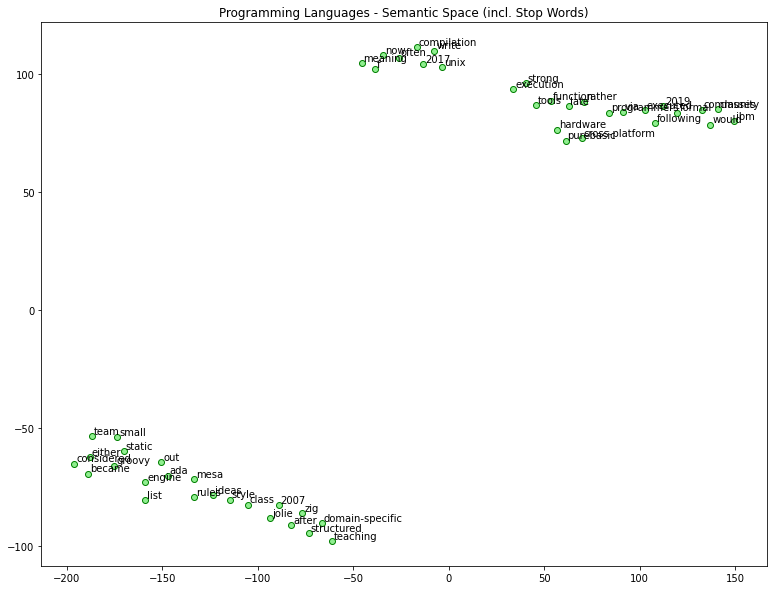

In [ ]:
# Visualize semantic space for embeddings with stop words
words = w2v_programming_sw.wv.index2word[300:350]      # get the word forms of vocabulary sample
wvs = w2v_programming_sw.wv[words]                     # get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)    # dimension-reduction 
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(13, 10))
plt.title('Programming Languages - Semantic Space (incl. Stop Words)')
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

In the semantic space above, different POS tags (nouns, adjectives, etc.) as well as named entities can be detected. However, it is difficult to spot higher-level concepts at this point, even though clusters can be seen.

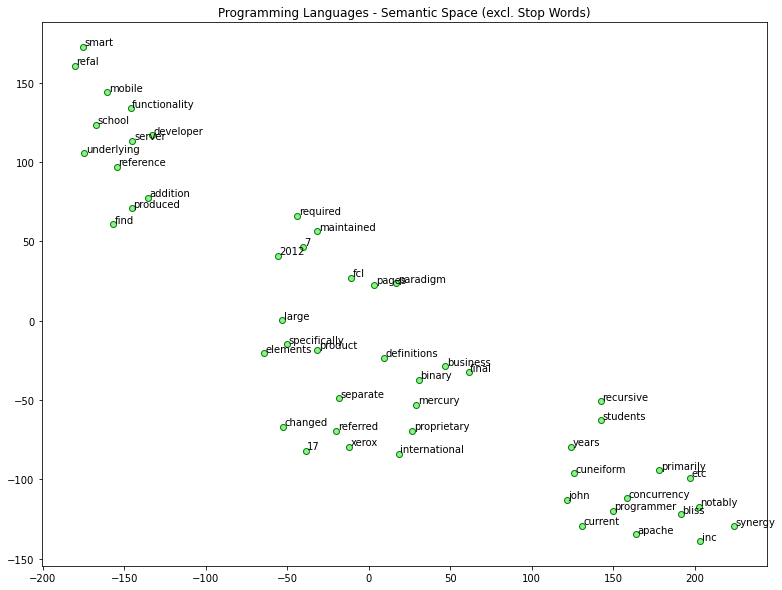

In [ ]:
# Visualize semantic space for embeddings without stop words
words = w2v_programming.wv.index2word[300:350]      # get the word forms of vocabulary sample
wvs = w2v_programming.wv[words]                     # get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)    # dimension-reduction 
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(13, 10))
plt.title('Programming Languages - Semantic Space (excl. Stop Words)')
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

Here, the tokens are more scattered throughout the plot. Nevertheless, the named entities are more diverse in this semantic space since we find entities like people's names ('john'), company names ('xerox') and dates ('2012'). The reason behind this could be that unecessary stop words are left out.  

### **Category: Literary Genres**

The same appraoch and assumption as for the category 'Programming Languages' is made for the category 'Literary Genres'. 

In [ ]:
# Create a subset with programming languages only
df_literature = df[df['Category'] == 'Literature']

In [ ]:
# Set seed for reproducibility
random.seed(2)
# Set values for parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

# Create model and train embedding space using word2vec architecture ('CBOW' as training algorithm) - stop words are included
w2v_literature_sw = Word2Vec(sentences=df_literature['Tokens'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0) # CBOW
# Create model and train embedding space using word2vec architecture ('CBOW' as training algorithm) - stop words are excluded
w2v_literature = Word2Vec(sentences=df_literature['Tokens (w/o Stop Words)'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0) # CBOW

In [ ]:
# Get five most similar words to each of the five most frequent words (with stop words)
for word in top5_literature:
  print(word+':', w2v_literature_sw.wv.most_similar(word, topn=5))
print(182*'=')
# Get five most similar words to each of the five most frequent words (without stop words)
for word in top5_literature:
  print(word+':', w2v_literature.wv.most_similar(word, topn=5))

fiction: [('by', 0.9999427795410156), ('a', 0.9999414682388306), ('in', 0.9999380707740784), ('it', 0.9999368190765381), ('for', 0.9999361634254456)]
genre: [('in', 0.9999269247055054), ('it', 0.9999233484268188), ('and', 0.9999218583106995), ('of', 0.9999218583106995), ('author', 0.9999176859855652)]
novel: [('in', 0.9999440908432007), ('of', 0.9999414682388306), ('are', 0.9999385476112366), ('a', 0.9999359846115112), ('or', 0.9999326467514038)]
novels: [('to', 0.9999433755874634), ('have', 0.9999427795410156), ('in', 0.9999418258666992), ('by', 0.9999415874481201), ('and', 0.9999409317970276)]
literature: [('in', 0.9999381303787231), ('or', 0.9999370574951172), ('to', 0.999936580657959), ('by', 0.999935507774353), ('with', 0.999935507774353)]
fiction: [('genre', 0.9983487725257874), ('de', 0.9980147480964661), ('novels', 0.9979262351989746), ('novel', 0.9979243874549866), ('literature', 0.9977949857711792)]
genre: [('novel', 0.998380184173584), ('fiction', 0.9983488321304321), ('de',

The assumption seems also to be true for this category as expected and the same pattern can be seen as for the category 'Programming Languages'. 

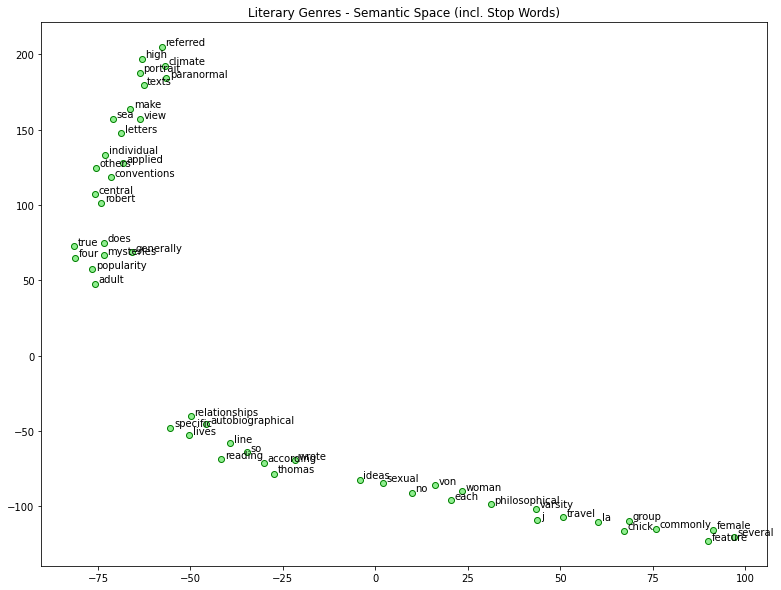

In [ ]:
# Visualize semantic space for embeddings with stop words
words = w2v_literature_sw.wv.index2word[300:350]      # get the word forms of vocabulary sample
wvs = w2v_literature_sw.wv[words]                     # get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)    # dimension-reduction 
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(13, 10))
plt.title('Literary Genres - Semantic Space (incl. Stop Words)')
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

Again, there are clusters visible but higher-order concepts are still hard to detect. 

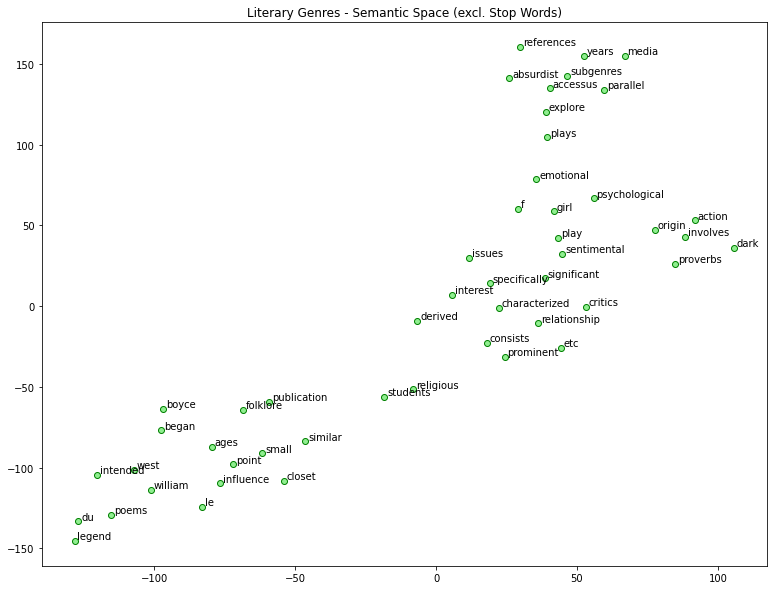

In [ ]:
# Visualize semantic space for embeddings without stop words
words = w2v_literature.wv.index2word[300:350]      # get the word forms of vocabulary sample
wvs = w2v_literature.wv[words]                     # get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)    # dimension-reduction 
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(13, 10))
plt.title('Literary Genres - Semantic Space (excl. Stop Words)')
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

Again, the tokens for the word embeddings without stop words are more scattered throughout the plot (clusters are less obvious). What caught the attention is that French words like 'du' and 'le' are to be found in the semantic space. 

### **Categories: Programming Languages & Literary Genres**

In this section, the word embedding is based on the descriptions of both categories without any distinction between them. The assumption is that the similarity between two words that have been very similar based on the categorical word embeddings show a lower similarity based on the general word embedding.

The word embedding is trained on the tokens where the stop words are excluded since we are more interested in similarities between content words.


In [ ]:
# Set seed for reproducibility
random.seed(3)
# Set values for parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count
# Create model and train embedding space using word2vec architecture
w2v_all = Word2Vec(sentences=df['Tokens (w/o Stop Words)'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [ ]:
# Get five most similar words to each of the five most frequent words of the category 'Programming' (without stop words)
for word in top5_programming:
  print(word+':', w2v_all.wv.most_similar(word, topn=5))
print(182*'=')
# Get five most similar words to each of the five most frequent words of the category 'Literature' (without stop words)
for word in top5_literature:
  print(word+':', w2v_all.wv.most_similar(word, topn=5))

language: [('programming', 0.9998916983604431), ('code', 0.9998810291290283), ('written', 0.9998723268508911), ('term', 0.9998719692230225), ('java', 0.999869167804718)]
programming: [('language', 0.9998916983604431), ('later', 0.9998513460159302), ('code', 0.9998441934585571), ('developed', 0.9998432397842407), ('literature', 0.9998413324356079)]
languages: [('language', 0.99982750415802), ('code', 0.9998194575309753), ('features', 0.9997970461845398), ('written', 0.99979567527771), ('programming', 0.9997924566268921)]
code: [('language', 0.9998809695243835), ('written', 0.9998565912246704), ('genre', 0.9998462200164795), ('programming', 0.9998440742492676), ('later', 0.9998435378074646)]
developed: [('language', 0.9998602867126465), ('programming', 0.9998432397842407), ('code', 0.9998329877853394), ('written', 0.9998326301574707), ('java', 0.9998273849487305)]
fiction: [('genre', 0.999865710735321), ('written', 0.9998530149459839), ('language', 0.9998489022254944), ('program', 0.9998

From the output above it can be noticed that the five most similar words to every Top5 word per category have sometimes changed. For example the most frequent word 'language' in the category 'Programming Languages' shows now high similarities to words on a more general level like 'written' (i.e., within more general or less domain-specific texts, 'language' and 'written' are probably more often combined). 

In [ ]:
# Compute similarity between words 'programming' and 'java' for the word embeddings based on the category 'Programming Languages'
print('Similarity score (w2v_programming): ', w2v_programming.wv.similarity('programming', 'java'))
print('Similarity score (w2v_all): ', w2v_all.wv.similarity('programming', 'java'))

Similarity score (w2v_programming):  0.998699
Similarity score (w2v_all):  0.99979234


In [ ]:
# Compute similarity between words 'fiction' and 'romance' for the word embeddings based on the category 'Literary Genres'
print('Similarity score (w2v_literature): ', w2v_literature.wv.similarity('fiction', 'romance'))
print('Similarity score (w2v_all): ', w2v_all.wv.similarity('fiction', 'romance'))

Similarity score (w2v_literature):  0.997835
Similarity score (w2v_all):  0.9998116


The two samples above do not verify the assumption made at the beginning of this section - the opposite seems to be the case. The similarity between two words seems to be higher in the general word embeddings than in the category-specific embeddings. 

## **Pre-trained Word Embeddings**

In this chapter, the pre-trained word embeddings from *GloVe* and *Fasttext* are used to derive the most similar words of the Top5 per category. The outputs are then compared to the self-trained word embeddings.

It is expected that the most similar words in the pre-trained embeddings differ from the one's of the self-trained embeddings. The reason behind this is that the pre-trained word embeddings are not category or domain-specific and were trained on larger datasets and therefore more general (i.e., in the sense of that similar words tend to be synonyms more often). 

### **GloVe**

In [ ]:
# Download pre-trained GloVe embeddings
glove_vectors = api.load("glove-wiki-gigaword-100") # Glove vectors

In [ ]:
# Get five most similar words to each of the five most frequent words of the category 'Programming' (without stop words)
for word in top5_programming:
  print(word+':', glove_vectors.most_similar(word, topn=5))
print(182*'=')
# Get five most similar words to each of the five most frequent words of the category 'Literature' (without stop words)
for word in top5_literature:
  print(word+':', glove_vectors.most_similar(word, topn=5))

language: [('languages', 0.8260655999183655), ('word', 0.746408224105835), ('spoken', 0.7381493449211121), ('arabic', 0.7318817377090454), ('english', 0.7214903831481934)]
programming: [('network', 0.712138295173645), ('format', 0.7065715789794922), ('broadcast', 0.7059512734413147), ('channels', 0.691154956817627), ('programs', 0.6877143979072571)]
languages: [('language', 0.8260655403137207), ('dialects', 0.78934246301651), ('dialect', 0.7077823877334595), ('spoken', 0.7077775001525879), ('arabic', 0.6551462411880493)]
code: [('codes', 0.8177565336227417), ('rules', 0.715435802936554), ('system', 0.6840112209320068), ('regulations', 0.6531774997711182), ('standard', 0.6425492763519287)]
developed: [('develop', 0.7402546405792236), ('developing', 0.7249395847320557), ('created', 0.7141376733779907), ('evolved', 0.704723596572876), ('introduced', 0.7007111310958862)]
fiction: [('novels', 0.8623112440109253), ('novel', 0.8232017755508423), ('fantasy', 0.8110861778259277), ('anthology', 

It can be seen that the assumption made seems to be correct - there is less domain-specificity in the most similar words. For example programming languages like 'Java' are no more retrieved as most similar word to any of the Top5 words of the corresponding category. The same is true for the category 'Literary Genres' where the most similar words tend to be words of similar meaning like 'novel' and 'story'. 

In general it is noticable that the similarity scores are lower for the pre-trained word embeddings.

### **Fasttext**

In [ ]:
# Download pre-trained Fasttext embeddings
ft_vectors = api.load('fasttext-wiki-news-subwords-300')  

In [ ]:
# Get five most similar words to each of the five most frequent words of the category 'Programming' (without stop words)
for word in top5_programming:
  print(word+':', ft_vectors.most_similar(word, topn=5))
print(182*'=')
# Get five most similar words to each of the five most frequent words of the category 'Literature' (without stop words)
for word in top5_literature:
  print(word+':', ft_vectors.most_similar(word, topn=5))

language: [('langauge', 0.8434085845947266), ('langauage', 0.8207874298095703), ('languages', 0.8104431629180908), ('langugage', 0.8011747598648071), ('language-', 0.7960715293884277)]
programming: [('programing', 0.8730173110961914), ('non-programming', 0.8183146119117737), ('pre-programming', 0.7905724048614502), ('counter-programming', 0.7721990942955017), ('programmings', 0.768936276435852)]
languages: [('langauges', 0.8391832113265991), ('langauages', 0.8329509496688843), ('languages-', 0.8279915452003479), ('languges', 0.8105027675628662), ('language', 0.8104431629180908)]
code: [('codes', 0.8428937196731567), ('code1', 0.7793288230895996), ('non-code', 0.7749810218811035), ('code-', 0.7486314177513123), ('C-code', 0.7368246912956238)]
developed: [('devloped', 0.8076478242874146), ('developped', 0.804941713809967), ('co-developed', 0.7814486026763916), ('implemented', 0.7763727903366089), ('utilized', 0.7753407955169678)]
fiction: [('fictions', 0.8164106607437134), ('non-fiction'

The difference between pre-trained and self-trained is even bigger for Fasttext whereby the most similar words are mostly syntacticly similar (i.e., plural forms or forms where the base stem is extended like 'fiction' and 'fictionality'). 

## **Transfer Learning**

The idead of transfer learning is that the word embeddings are not only trained on own data but rather combined with already pre-trained word embeddings. In other words, the GloVe word vectors are used as a baseline and fine-tuned with the self-trained embeddings to fit the data more accurately. 

The assumption is that the word embeddings based on transfer learning 'make more sense' and are less prone to overfitting because they incorporate basic English from the pre-trained embeddings already. 

In [ ]:
random.seed(4)
# Add GloVe's vocabulary and weights to Word2Vec model for programming languages
w2v_programming.build_vocab([list(glove_vectors.vocab.keys())], update=True)

# Train extended Word2Vec model
total_examples = w2v_programming.corpus_count
w2v_programming.train(sentences=df_programming['Tokens (w/o Stop Words)'], total_examples=total_examples, epochs=w2v_programming.epochs)
w2v_programming_tl = w2v_programming.wv

In [ ]:
# Add GloVe's vocabulary and weights to Word2Vec model for literary genres
w2v_literature.build_vocab([list(glove_vectors.vocab.keys())], update=True)

# Train extended Word2Vec model
total_examples = w2v_literature.corpus_count
w2v_literature.train(sentences=df_literature['Tokens (w/o Stop Words)'], total_examples=total_examples, epochs=w2v_literature.epochs)
w2v_literature_tl = w2v_literature.wv

In [ ]:
# Get five most similar words to each of the five most frequent words of the category 'Programming' (without stop words)
for word in top5_programming:
  print(word+':', w2v_programming_tl.most_similar(word, topn=5))
print(182*'=')
# Get five most similar words to each of the five most frequent words of the category 'Literature' (without stop words)
for word in top5_literature:
  print(word+':', w2v_literature_tl.most_similar(word, topn=5))

language: [('languages', 0.999947190284729), ('software', 0.9999450445175171), ('design', 0.9999427795410156), ('programming', 0.9999420642852783), ('implementation', 0.9999407529830933)]
programming: [('language', 0.9999420642852783), ('languages', 0.9999251365661621), ('developed', 0.9999188184738159), ('program', 0.9999182224273682), ('system', 0.9999167919158936)]
languages: [('language', 0.999947190284729), ('code', 0.9999425411224365), ('implementation', 0.9999379515647888), ('features', 0.9999346733093262), ('development', 0.9999314546585083)]
code: [('languages', 0.9999425411224365), ('implementation', 0.99993497133255), ('language', 0.9999344348907471), ('available', 0.9999279975891113), ('compiler', 0.9999268651008606)]
developed: [('language', 0.9999302625656128), ('software', 0.9999299645423889), ('programming', 0.9999188184738159), ('languages', 0.9999184608459473), ('use', 0.9999179840087891)]
fiction: [('genre', 0.9999357461929321), ('work', 0.9999290704727173), ('litera

From the output above it seems that the most similar words do make more sense and are less domain-specific. For example, it makes more sense that the word 'programming' is more often combined with words like 'system' and 'program' rather than with 'Java' in practice. 

## **Domain-specific Words**

In this section, is is checked whether the similarity scores of the most frequent words differ between self-trained and pre-trained word embeddings for domain-specific words. 

For each category, one domain-specific word is chosen based on the vocabulary of the self-trained embeddings (because there are no similarity scores for words that do not appear in the self-trained Word2Vec word embeddings). 

In [ ]:
# Compare five most similar words to domain-specific word 'compiler' (category: 'Programming Languages') between self-trained and pre-trained (GloVe) word embeddings
print('Self-trained: ', w2v_programming.most_similar('compiler', topn=5))
print('Pre-trained (GloVe): ', glove_vectors.most_similar('compiler', topn=5))

Self-trained:  [('code', 0.9999269247055054), ('languages', 0.9999213218688965), ('design', 0.9999202489852905), ('implementation', 0.9999164342880249), ('language', 0.9999101161956787)]
Pre-trained (GloVe):  [('compilers', 0.7912998795509338), ('c++', 0.7526918649673462), ('fortran', 0.7101908922195435), ('implementations', 0.6381438970565796), ('assembler', 0.6325817108154297)]


In [ ]:
# Compare five most similar words to domain-specific word 'poetry' (category: 'Literary Genres') between self-trained and pre-trained (GloVe) word embeddings
print('Self-trained: ', w2v_literature.most_similar('poetry', topn=5))
print('Pre-trained (GloVe): ', glove_vectors.most_similar('poetry', topn=5))

Self-trained:  [('later', 0.999896764755249), ('written', 0.999891996383667), ('century', 0.9998892545700073), ('term', 0.9998822212219238), ('literature', 0.9998817443847656)]
Pre-trained (GloVe):  [('poems', 0.8494598865509033), ('literature', 0.8390864133834839), ('prose', 0.8041950464248657), ('literary', 0.8028783798217773), ('essays', 0.7605502605438232)]


As already expected, the most similar words for the chosen domain-specific words differ between the self-trained and pre-trained word embeddings. The similar words of the self-trained embeddings are more tied to the content of the input text where they have been trained on whereby for the pre-trained embeddings, they again seem to be more general (i.e., plural forms). 

## **WordNet**

In this section synsets for the most frequent words in both categories are retrieved. 

In [ ]:
# Get synsets of five most frequent words of both categories 
for word in top5_programming:
  print(word, ':', wn.synsets(f'{word}'))
print(182*'=')
for word in top5_literature:
  print(word, ':', wn.synsets(f'{word}'))

language : [Synset('language.n.01'), Synset('speech.n.02'), Synset('lyric.n.01'), Synset('linguistic_process.n.02'), Synset('language.n.05'), Synset('terminology.n.01')]
programming : [Synset('scheduling.n.01'), Synset('programming.n.02'), Synset('program.v.01'), Synset('program.v.02')]
languages : [Synset('language.n.01'), Synset('speech.n.02'), Synset('lyric.n.01'), Synset('linguistic_process.n.02'), Synset('language.n.05'), Synset('terminology.n.01')]
code : [Synset('code.n.01'), Synset('code.n.02'), Synset('code.n.03'), Synset('code.v.01'), Synset('code.v.02')]
developed : [Synset('develop.v.01'), Synset('evolve.v.01'), Synset('develop.v.03'), Synset('grow.v.08'), Synset('originate.v.01'), Synset('build_up.v.05'), Synset('explicate.v.02'), Synset('train.v.01'), Synset('develop.v.09'), Synset('develop.v.10'), Synset('modernize.v.02'), Synset('develop.v.12'), Synset('develop.v.13'), Synset('develop.v.14'), Synset('develop.v.15'), Synset('develop.v.16'), Synset('develop.v.17'), Synset

From the synsets it can be seen that pre-trained word embeddings sometimes make use of them and output them as very similar to a given word. For example for the given word 'programming', there exists the synset 'program' which is also retrieved from GloVe as a very similar word (but in its plural form 'programs'). It seems that pre-trained word embeddings make use of different meanings of a word in a more extense manner than self-trained embeddings do since they are more tied to a specific domain. 

## **Summary & Learnings**

The greatest learning I have drawn from this project is that the implementation of word embeddings heavily depends on the use case and the problem to be solved. 

With regard to self-trained word embeddings, they can be trained on a chosen domain and therefore be quite accurate with good results if they are applied  on the corresponding domain. On the other hand, this customization could also turn into a disadvantage whereby the embedding really only makes sense with regard to the input data. Furthermore, to get high-quality word embeddings that are self-trained, a large amount of data is needed and it is assumed that training time could heavily rise.  

Pre-trained word embeddings as the other option are easy to access and are less prone to overfitting since they are trained on huge and more general datasets (less domain-specificity). The performance of the pre-trained word embeddings strongly depends on the chosen embeddings (i.e., GloVe or Fasttext). The results with GloVe were better than with Fasttext which mostly returned words with high similarity that share the same stem as the input word (i.e., 'fictionality' is highly similar to 'fiction'). In addition, pre-trained embeddings sometimes have difficulties grasping the context. For example the words 'arabic' and 'english' show high similarities to 'language' according to GloVe, but 'language' is the most frequent word in the category 'Programming Languages' (with that in mind, the words 'arabic' and 'english' do not make that much sense in this context). 

The best results were obtained by using transfer learning which combines self-trained and pre-trained word embeddings. In general, a great learning is that pre-trained word embeddings can serve as a good baseline and be extended with self-trained embeddings if performance is not accurate enough (that is the basic idea of transfer learning). This appraoch leads not only to good results but is also time-efficient. 